<a href="https://colab.research.google.com/github/IT21319792/INTERVIEW-PROCESSING-SYSTEM/blob/IT21319792-Boshitha_Gunarathna-Model_Train/Voice_Confidence_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC  # Consider SVM as an alternative
import matplotlib.pyplot as plt

In [3]:
confident_folder = '/content/drive/MyDrive/dataset/Voicedata/confident'
non_confident_folder = '/content/drive/MyDrive/dataset/Voicedata/Non-confident'


In [10]:
# Function to add noise
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

In [11]:
# Function to pitch shift audio
def pitch_shift(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr, n_steps=n_steps)

In [12]:
# Function to time-stretch audio
def time_stretch(audio, rate=1.1):
    return librosa.effects.time_stretch(audio, rate)

In [15]:
# Function to extract features from audio files
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=None)

    # Feature Extraction
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0])

    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr))

       # Additional features
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))

    return np.hstack([mfccs_mean, pitch_mean, spectral_centroid, spectral_bandwidth, chroma, zero_crossing_rate, spectral_rolloff])



In [19]:
import os

non_confident_folder = '/content/drive/MyDrive/dataset/Voicedata/Non-confident'

# List all files in the folder
files = os.listdir(non_confident_folder)

# Filter and print files that are not .wav
non_wav_files = [file for file in files if not file.endswith('.wav')]

print("Files that are not .wav:")
print(non_wav_files)


Files that are not .wav:
[]


In [22]:
def load_audio_files_combined(folder):
    audio_features = []
    labels = []

    if not os.listdir(folder):
        print(f'No files found in {folder}')
        return np.array(audio_features), np.array(labels)

    for file in os.listdir(folder):
        if file.endswith('.wav'):
            file_path = os.path.join(folder, file)
            print(f'Processing {file_path}')

            # Load audio file
            try:
                audio, sr = librosa.load(file_path, sr=None)
                # Check if audio is not empty
                if len(audio) == 0:
                    print(f'Warning: {file_path} is empty or unreadable.')
                    continue

                # Extract features as before
                features = extract_features(file_path)
                audio_features.append(features)

                # Use folder name as label
                labels.append(folder.split('/')[-1])
            except Exception as e:
                print(f'Error loading {file_path}: {e}')

    return np.array(audio_features), np.array(labels)


    # Load data from the confident and non-confident folders
confident_folder = '/content/drive/MyDrive/dataset/Voicedata/confident'
non_confident_folder = '/content/drive/MyDrive/dataset/Voicedata/Non-confident'
confident_features, confident_labels = load_audio_files_combined(confident_folder)
non_confident_features, non_confident_labels = load_audio_files_combined(non_confident_folder)



Processing /content/drive/MyDrive/dataset/Voicedata/confident/01-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/02-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/03-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/06-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/04-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/07-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/09-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/08-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/101-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/10-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/100-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/102-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/104-1.wav
Processing /content/drive/MyDrive/dataset/Voicedata/confident/103-1.wav
P

In [23]:
# Combine features and labels
X = np.vstack((confident_features, non_confident_features))
y = np.hstack((confident_labels, non_confident_labels))

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [35]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [36]:
# Make predictions and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.82
               precision    recall  f1-score   support

Non-confident       0.86      0.80      0.83       107
    confident       0.79      0.85      0.82        93

     accuracy                           0.82       200
    macro avg       0.82      0.83      0.82       200
 weighted avg       0.83      0.82      0.83       200



In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],        # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]         # Minimum number of samples required to be at a leaf node
}

# Initialize the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Use the best estimator to predict on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance of the best model
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best model: {accuracy:.2f}")

# Print a detailed classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy of the best model: 0.84
               precision    recall  f1-score   support

Non-confident       0.87      0.82      0.85       107
    confident       0.81      0.86      0.83        93

     accuracy                           0.84       200
    macro avg       0.84      0.84      0.84       200
 weighted avg       0.84      0.84      0.84       200



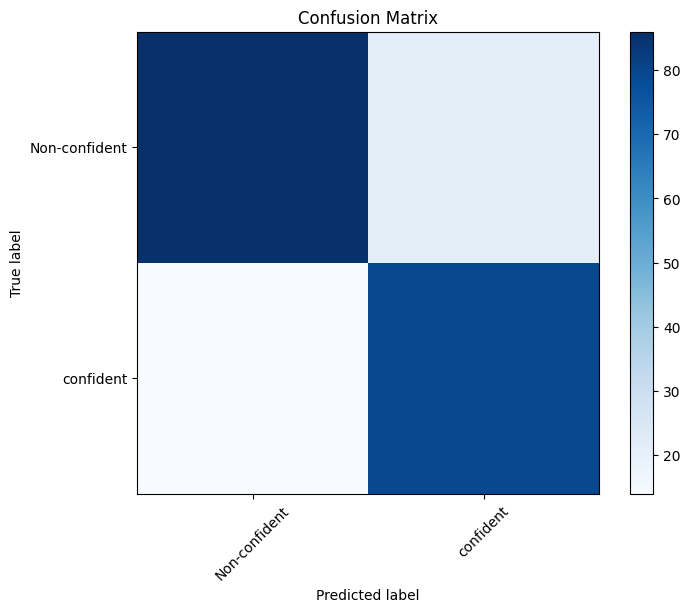

In [37]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(le.classes_)), le.classes_, rotation=45)
plt.yticks(np.arange(len(le.classes_)), le.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [38]:
import joblib

# Save the trained model
joblib.dump(model, '/content/drive/MyDrive/dataset/confidence_model.pkl')


['/content/drive/MyDrive/dataset/confidence_model.pkl']

In [39]:
# Load the trained model
loaded_model = joblib.load('/content/drive/MyDrive/dataset/confidence_model.pkl')


In [42]:
def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    # Extract fundamental frequency (F0)
    pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches) else 0  # Get the mean pitch, avoid empty array

    # Extract Spectral Centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))

    # Extract Spectral Bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))

    # Extract Chroma features
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr))

    # Combine all features into one feature vector
    features = np.hstack([mfccs_mean, pitch_mean, spectral_centroid, spectral_bandwidth, chroma])

    # Check if we have the correct number of features (19) as expected
    expected_feature_count = 19  # Adjust according to your training setup
    while len(features) < expected_feature_count:
        features = np.append(features, 0)  # Pad with zeros if needed
    return features


In [43]:
# Replace 'your_audio_file.wav' with the path to your audio file
audio_file_path = '/content/test.wav'
features = preprocess_audio(audio_file_path)

# Reshape the features to match the model input shape
features_reshaped = features.reshape(1, -1)

# Make a prediction
predicted_class = loaded_model.predict(features_reshaped)
predicted_label = le.inverse_transform(predicted_class)

print(f'The predicted confidence level for the audio file is: {predicted_label[0]}')


The predicted confidence level for the audio file is: confident
